In [1]:
# import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl 
mpl.rcParams["figure.dpi"] = 150
import seaborn as sns
import os
import datetime as dt
# enable copy on write (default in pandas 3.0)
pd.options.mode.copy_on_write = True

In [2]:
def read_merged(weather, year):
    return pd.read_csv('../merged/merged_{}_{}.csv.gz'.format(weather, year))


In [3]:
tor_2019 = read_merged('tornados', 2019)

In [4]:
tor_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58403 entries, 0 to 58402
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            58403 non-null  int64  
 1   DATE                  58403 non-null  object 
 2   LAT_mean              58403 non-null  float64
 3   LON_mean              58403 non-null  float64
 4   AVGDV_max             58403 non-null  int64  
 5   LLDV_max              58403 non-null  int64  
 6   MXDV_max              58403 non-null  int64  
 7   MXDV_HEIGHT_max       58403 non-null  int64  
 8   DEPTH_max             58403 non-null  float64
 9   MAX_SHEAR_max         58403 non-null  int64  
 10  MAX_SHEAR_HEIGHT_max  58403 non-null  float64
 11  county                58403 non-null  object 
 12  state                 58403 non-null  object 
 13  power_outage          58403 non-null  bool   
dtypes: bool(1), float64(4), int64(6), object(3)
memory usage: 5.8+ MB


In [5]:
#del light_2019['#ZDAY']
del tor_2019['Unnamed: 0']

In [6]:
tor_2019['DATE'] = pd.to_datetime(tor_2019['DATE'])
tor_2019['Month'] = tor_2019['DATE'].dt.month

In [7]:
tor_2019.columns

Index(['DATE', 'LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max',
       'county', 'state', 'power_outage', 'Month'],
      dtype='object')

In [8]:
tor_2019['power_outage'].value_counts(normalize=True)

False    0.957297
True     0.042703
Name: power_outage, dtype: float64

### Let's try XGBOOST

In [9]:
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, make_scorer


In [11]:
tor_train, tor_test = train_test_split(tor_2019.copy(), shuffle=True, test_size=0.2, stratify=tor_2019.power_outage)

In [12]:
xgb_clas1 = xgboost.XGBClassifier(learning_rate=.1,
                                   max_depth=3,
                                   n_estimators=200, objective='binary:logistic')

In [13]:
features = ['LAT_mean', 'LON_mean', 'AVGDV_max', 'LLDV_max', 'MXDV_max',
       'MXDV_HEIGHT_max', 'DEPTH_max', 'MAX_SHEAR_max', 'MAX_SHEAR_HEIGHT_max', 'Month']

In [14]:
xgb_clas1.fit(tor_train[features], tor_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
prec = precision_score(xgb_clas1.predict(tor_train[features]), tor_train['power_outage'])
recall = recall_score(xgb_clas1.predict(tor_train[features]), tor_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.13634085213032582
recall:  0.6522781774580336


In [35]:
pred = xgb_clas1.predict(light_train[features])
acc, prec, recall = accuracy_score(pred, light_train.power_outage), precision_score(pred, light_train.power_outage), recall_score(pred, light_train.power_outage)

In [18]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (1, 20,  1),
    'n_estimators': range(100, 480, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)


In [15]:
grid_search.fit(tor_train[features], tor_train['power_outage'])

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/painchess/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, nthread=4,
                                     num_parallel_tree=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.25, 0.35],
                         'max_depth': range(14, 16),
                         'n_estimators': range(300, 380, 20)},
             scoring='f1', verbose=True)

In [17]:
grid_search.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.35, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [16]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

{(0.25, 14, 300): 0.2857932269483647,
 (0.25, 14, 320): 0.28781746197011815,
 (0.25, 14, 340): 0.28768882580160365,
 (0.25, 14, 360): 0.28699956266677995,
 (0.25, 15, 300): 0.2880848635984533,
 (0.25, 15, 320): 0.2874323866628078,
 (0.25, 15, 340): 0.2874634334101201,
 (0.25, 15, 360): 0.28750286100023736,
 (0.35, 14, 300): 0.28877211261110314,
 (0.35, 14, 320): 0.2886573734693859,
 (0.35, 14, 340): 0.28832402840806853,
 (0.35, 14, 360): 0.28830745853437034,
 (0.35, 15, 300): 0.28860761820983016,
 (0.35, 15, 320): 0.2879830032876731,
 (0.35, 15, 340): 0.2882661314676719,
 (0.35, 15, 360): 0.2879115381839682}

In [117]:
best_param = pars[np.argmax(scores)]

In [118]:
best_param

(0.2, 10, 180)

In [40]:
best_model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
   learning_rate=.3,
    max_depth=14,
    n_estimators=300) 

In [41]:
best_model.fit(light_train[features],light_train['power_outage'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.5012381866882296
recall:  0.8653695140040136


In [145]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

precision:  0.6274321524233082
recall:  0.8734039185338914


In [151]:
best_model.get_booster().get_score(importance_type='gain')

{'CENTERLON': 0.7193518280982971,
 'CENTERLAT': 0.6461976766586304,
 'log_total_count': 0.36021170020103455,
 'Month': 4.358182907104492}

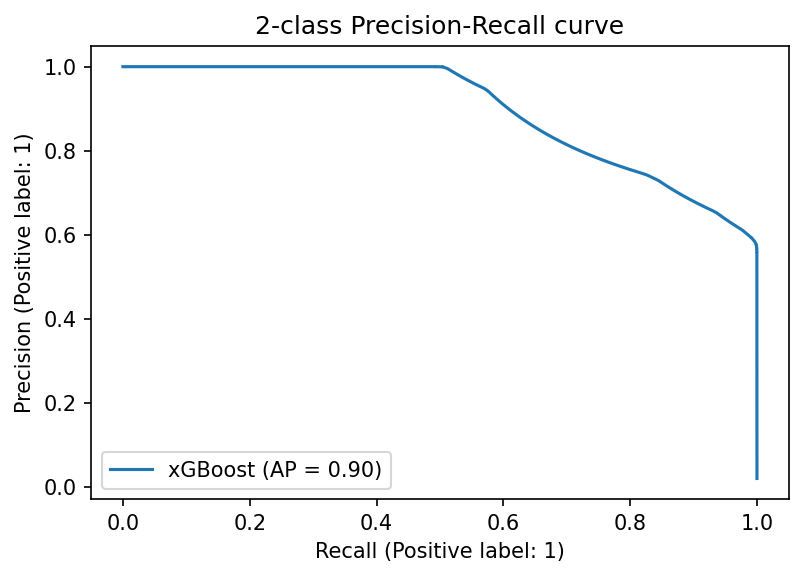

In [142]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, light_train[features], light_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")

## Work on the Balanced Dataset

In [44]:
outage = light_train[light_train['power_outage']==True]
no_outage = light_train[light_train['power_outage']==False]
no_outage= no_outage.sample(n=3*len(outage), random_state=101)
balanced = pd.concat([outage,no_outage],axis=0)

In [45]:
balanced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158296 entries, 2080128 to 1658115
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   CENTERLON        158296 non-null  float64       
 1   CENTERLAT        158296 non-null  float64       
 2   TOTAL_COUNT      158296 non-null  int64         
 3   DATE             158296 non-null  datetime64[ns]
 4   county           158296 non-null  object        
 5   state            158296 non-null  object        
 6   power_outage     158296 non-null  bool          
 7   log_total_count  158296 non-null  float64       
 8   Month            158296 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 11.0+ MB


In [46]:
features = ['CENTERLON', 'CENTERLAT', 'log_total_count', 'Month']

In [47]:
model = xgboost.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42)

parameters = {
    'max_depth': range (1, 16,  2),
    'n_estimators': range(100, 500, 40),
    'learning_rate': [0.01, 0.03, 0.1, 0.3]
}

grid_search = GridSearchCV(model,
    param_grid=parameters,
    scoring='f1',
    cv = 5,
    n_jobs = 10,
    verbose=True)

In [ ]:
grid_search.fit(balanced[features], balanced['power_outage'])

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


/home/painchess/.local/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
grid_search.best_estimator_

In [ ]:
res = grid_search.cv_results_
pars = [tuple(par.values()) for par in res['params']]
scores = np.array(res['mean_test_score'])
param_scores = dict(zip(pars, scores))
param_scores

In [ ]:
prec = precision_score(best_model.predict(light_train[features]), light_train['power_outage'])
recall = recall_score(best_model.predict(light_train[features]), light_train['power_outage'])
print("precision: ", prec)
print("recall: ", recall)

In [ ]:
best_model.get_booster().get_score(importance_type='gain')

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    best_model, light_train[features], light_train['power_outage'], name="xGBoost")
_ = display.ax_.set_title("2-class Precision-Recall curve")